# **Práctica Deep Learning**  



Predicción del precio de las habitaciones de AirBnb combinando las **imágenes** disponibles del dataset airbnb junto con los **datos numéricos**, mediante:

*   Regresión
*   Clasificación




#### **Cargar las librerías y funciones necesarias**

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [3]:
# Cargamos librerías necesarias
import numpy  as np  
import pandas as pd

import matplotlib.pyplot as plt # para dibujar
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Tratamiento de imágenes
import imageio as io
import cv2

# Sets the value of the specified option
# Para visualizar la información de todas las filas pj dtypes o head().T aplico set_option en max_rows 
pd.set_option('display.max_rows', None)
# Para visualizar la información de la matriz de correlación
pd.set_option('display.max_columns', None)

In [4]:
# Función que realiza comprobaciones sobre una columna de un dataframe
def check_column(df, col_name):
    values_unique = len(df[col_name].unique())
    values_nan = df[col_name].isnull().sum()
    portmissing = round((df[col_name].isnull().sum()/len(df))*100, 4)
    
    print (f'{col_name} consta de: {values_unique} valores distintos de un total de {len(df)}')
    print (f'{col_name} consta de: {values_nan} valores ausentes, {portmissing}%')
    
    df[col_name].value_counts().head()

In [5]:
# esta es la función que se descargará la imagen y devolverá la imagen y el 
# índice indicando la posición donde se incrustará la imagen en nuestro array
def get_image(data_url, target_size=(224, 224)):
    idx, url = data_url
    try:
        img = io.imread(url)
        # hay alguna imagen en blanco y negro y daría error al incluirla en 
        # nuestro array de imagenes que tiene 3 canales, así que convertimos
        # todas las imágenes que tengan menos de 3 dimensiones a color
        if img.ndim < 3:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, dsize=target_size)
        return img, idx
    except IOError as err:
        return (None, idx)

In [6]:
# Función que define la red MLP Multi-Layer Perceptron
# parámetro regress = True para problema de regresión con función de activación linear (sin función de activación) y 1 neurona
# parámetro regress = False para problema de clasificación con función de activación softmax indicando el nº de clases de la variable objetivo y este valor será el nº de neuronas 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def create_mlp(dim, regress):
	# define our MLP network
	model = Sequential()
	model.add(Dense(32, input_dim=dim, activation='relu'))
	model.add(Dense(18, activation='relu'))
	model.add(Dense(4, activation='relu'))
	# check to see if the regression node should be added with function activation linear
	# otherwise (classification) use softmax with the number of classes
	if regress:
		model.add(Dense(1, activation="linear"))
	else:
		model.add(Dense(5, activation="softmax"))  
  
	# return our model
	return model

In [7]:
# Función que realiza el preprocesado del data set df_airbnb si eliminar la columna Thumbnail Url
def process_datasetairbnb(df):

	columns_1drop = ['Listing Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 
					'Host URL', 'Host Thumbnail Url', 'Host Picture Url', 
					'ID', 'Scrape ID', 'Last Scraped', 'Calendar last Scraped', 'Weekly Price', 'Monthly Price',
					'Reviews per Month', 'Geolocation', 
					'Host ID', 'Host Name', 'Host Location', 'Host About', 'Host Neighbourhood',
					'Host Listings Count', 'Host Total Listings Count', 'Calculated host listings count']
	df.drop(columns_1drop, axis=1, inplace=True)  
	
	# Columnas a eliminar porque tiene un porcentaje superior al 90% de valores perdidos
	columns_2drop = ['Host Acceptance Rate', 'Square Feet', 'Has Availability', 'License', 'Jurisdiction Names']
	df.drop(columns_2drop, axis=1, inplace=True)  
	
	# Columnas a eliminar porque la información la podemos obtener de las variables Neighbourdhood, City y County Code
	columns_3drop = ['Street', 'State', 'Zipcode', 'Market', 'Smart Location', 'Country']
	df.drop(columns_3drop, axis=1, inplace=True)  

	# Filtro City  (alojamientos de Madrid)
	list_of_madrid = ['Madrid', 'Madrid, Comunidad de Madrid, ES', 'madrid', 'MADRID', 'las matas  madrid', 
					  'Boadilla del Monte', 'Delicias-Madrid', 'Delicias', 'Aravaca (Madrid)', 
					  'Chueca, Madrid', 'Madrid, Comunidad de Madrid, ESPANA']
	df_filtered = df[df['City'].isin(list_of_madrid)]
	# Aplicamos el filtro
	df = df[df['City'].isin(list_of_madrid)]

	# Filter Bathrooms 
	filter_bath0 = df['Bathrooms']!= 0
	df_filtered = df[filter_bath0]
	# Aplicamos el filtro
	df = df_filtered

	# Filter Price 
	filter_price = df['Price'] <= 250
	df_filtered = df[filter_price]
	# Aplicamos el filtro para Price
	df = df[filter_price]

	# Eliminamos los registros ausentes de la variable Thumbnail Url para trabajar con muestras con imágenes
	df.dropna(subset=['Thumbnail Url'], inplace=True)

	# Dataframe con las columnas desde Review Scores Rating hasta Review Scores Value 
	# para generar una nueva característica con la media de todas ellas
	df_review = df.loc[:,'Review Scores Rating':'Review Scores Value']
	df['Review Scores Mean'] = df_review.mean(axis=1)

	# Columnas a eliminar porque una alta correlación y esto origina valores redundantes
	columns_4drop = ['Accommodates', 'Availability 30', 'Availability 60', 'Availability 90',
					'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
					'Review Scores Communication', 'Review Scores Location', 
					'Review Scores Rating', 'Review Scores Value']
	df.drop(columns_4drop, axis=1, inplace=True) 

	# Columnas a eliminar 
	columns_6drop = ['Name', 'Summary', 'Space', 'Description', 'Notes', 'Transit', 'Access', 'Interaction', 
					'House Rules', 'Features']
	df.drop(columns_6drop, axis=1, inplace=True)  

	# Sustituimos los valores ausentes por la moda, es decir el valor que más se repite, en este caso within an hour
	df['Host Response Time'].fillna(df['Host Response Time'].mode()[0], inplace=True)
	# Sustituimos los valores ausentes por la moda, es decir el valor que más se repite, en este caso email,phone,reviews
	df['Host Verifications'].fillna(df['Host Verifications'].mode()[0], inplace=True)
	# Dataframe con la moda
	df_mode = pd.DataFrame({'variables': ['Host Response Time', 'Host Verifications'], 
                        'moda': [df['Host Response Time'].mode()[0], df['Host Verifications'].mode()[0]]})

	# Sustituimos los valores ausentes de la variable Neighbourhood por la variable Neighvourhood Group Cleansed
	df['Neighbourhood'].fillna(df['Neighbourhood Group Cleansed'], inplace=True)

	# En este caso decido sustituir los valores ausentes por "" para que en caso de tratar dicha variable la interpretación
	# sea más objetiva que con respecto al resto de alojamientos
	df['Amenities'].fillna("", inplace=True)

	# Columnas a eliminar según el análisis realizado
	columns_7drop = ['Experiences Offered', 'Neighborhood Overview', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed',
					 'City', 'Country Code', 'First Review', 'Last Review', 'Host Since']
	df.drop(columns_7drop, axis=1, inplace=True)  

	# Creación de nuevas características a partir de las variables Host Verifications y Amenities
	# Ambas variables contienen información separada por coma, de manera que podemos contabilizar el nº de elementos
	# para así tenerlo en cuenta como una nueva característica para estas variables
	df['Host Verifications'] = df['Host Verifications'].apply(lambda x: len(str(x).split(',')))
	df['Amenities'] = df['Amenities'].apply(lambda x: len(str(x).split(',')))

	# categ_variables: list of variables to encode
	categ_variables = ['Host Response Time', 'Neighbourhood', 'Property Type', 'Room Type', 'Bed Type',
					   'Calendar Updated', 'Cancellation Policy']
	# mean_map: dict, mapping to be used on validation/test datasets
	mean_map=dict()  
	for v in categ_variables:
		mean_encode = df.groupby(v)['Price'].mean()
		df[v]=df[v].map(mean_encode)
		mean_map[v] = mean_encode

	# Columnas o variables aún con valores ausentes
	df.dropna(subset=['Property Type'], inplace=True)
	df.dropna(subset=['Calendar Updated'], inplace=True)

	# Columnas o variables aún con valores ausentes
	null_columns = df.columns[df.isnull().any()]
	# Data frame con la media para las columnas o variables con valores ausentes
	df_mean=dict()
	for v in null_columns:
		df[v] = df[v].fillna(df[v].mean())
	
	return df

#### **Cargar Dataset airbnb**

In [8]:
# Montamos GDrive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
# Read a dot comma-separated values (csv) file into DataFrame called df_airbnb
df_airbnb = pd.read_csv('/content/drive/My Drive/airbnb_listings.csv', sep=';', decimal='.')   

print(f'Dimensiones del dataframe df_airbnb son: {df_airbnb.shape[0]} filas y {df_airbnb.shape[1]} columnas')

Dimensiones del dataframe df_airbnb son: 14780 filas y 89 columnas


In [ ]:
df_airbnb.describe()

,ID,Scrape ID,Host ID,Host Response Rate,Host Listings Count,Host Total Listings Count,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Calculated host listings count,Reviews per Month
count,1.478000e+04,1.478000e+04,1.478000e+04,12881.000000,14777.000000,14777.000000,14780.000000,14780.000000,14780.000000,14725.000000,14755.000000,14731.00000,598.000000,14763.000000,3590.000000,3561.000000,6256.000000,8687.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,11476.000000,11454.000000,11460.000000,11443.000000,11460.000000,11440.000000,11439.000000,14776.000000,11618.000000
mean,1.028089e+07,2.017037e+13,3.608080e+07,94.823461,12.513636,12.513636,40.497626,-3.858041,3.277808,1.281732,1.343816,2.04426,390.456522,73.561471,376.937883,1426.125246,189.226822,31.805341,1.589986,7.690460,3.050474,945.168742,8.954736,22.996211,39.869621,202.104465,22.632273,91.697978,9.416012,9.328883,9.621778,9.647033,9.532168,9.218201,9.486871,1.870014
std,5.564829e+06,5.667971e+08,3.425360e+07,15.215988,34.090223,34.090223,4.641387,14.123146,2.097291,0.658517,0.900078,1.61277,637.134930,72.062050,195.701043,1246.403853,115.151070,30.878599,1.182550,12.971352,12.266517,8439.321218,9.333252,19.731371,29.621456,127.886822,38.290244,8.989101,0.921938,0.989933,0.802736,0.767116,0.774527,0.950578,23.626014,1.867550
min,1.862800e+04,2.016010e+13,1.745300e+04,0.000000,0.000000,0.000000,-37.851182,-123.131344,1.000000,0.000000,0.000000,1.00000,0.000000,9.000000,70.000000,250.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.020000
25%,5.554732e+06,2.017041e+13,6.787360e+06,100.000000,1.000000,1.000000,40.409726,-3.707604,2.000000,1.000000,1.000000,1.00000,0.000000,34.000000,215.000000,720.000000,100.000000,15.000000,1.000000,0.000000,1.000000,365.000000,0.000000,4.000000,12.000000,78.000000,1.000000,89.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,1.000000,0.450000
50%,1.133492e+07,2.017041e+13,2.464875e+07,100.000000,2.000000,2.000000,40.419466,-3.700785,3.000000,1.000000,1.000000,2.00000,98.500000,55.000000,350.000000,1200.000000,150.000000,25.000000,1.000000,0.000000,2.000000,1125.000000,6.000000,20.000000,38.000000,239.000000,7.000000,94.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,2.000000,1.200000
75%,1.532631e+07,2.017041e+13,5.432919e+07,100.000000,6.000000,6.000000,40.430916,-3.684057,4.000000,1.000000,2.000000,2.00000,646.000000,86.000000,500.000000,1725.000000,200.000000,40.000000,2.000000,15.000000,3.000000,1125.000000,14.000000,38.000000,65.000000,319.000000,27.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,2.780000
max,1.910969e+07,2.017062e+13,1.247534e+08,100.000000,519.000000,519.000000,55.966912,153.371427,16.000000,8.000000,10.000000,16.00000,6997.000000,999.000000,999.000000,25000.000000,990.000000,662.000000,16.000000,500.000000,1125.000000,1000000.000000,30.000000,60.000000,90.000000,365.000000,446.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,145.000000,17.210000


In [10]:
# Realizamos el preprocesado  para obtener el data set airbnb limpio y menos complejo al reducir dimensiones
# y facilitar las tarea del problema de regresión y clasificación combinándolo con imágenes
df_airbnb_clean = process_datasetairbnb(df_airbnb)
print(f'Dimensiones del dataframe df_airbnb_clean son: {df_airbnb_clean.shape[0]} filas y {df_airbnb_clean.shape[1]} columnas')

Dimensiones del dataframe df_airbnb_clean son: 10593 filas y 26 columnas


In [ ]:
# Guardamos el df airbnb limpio
df_airbnb_clean.to_csv('/content/drive/My Drive/df_airbnb_clean.csv', sep=';', decimal='.', index=False)

In [ ]:
df_airbnb_clean.describe()

,Host Response Time,Host Response Rate,Host Verifications,Neighbourhood,Latitude,Longitude,Property Type,Room Type,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Availability 365,Number of Reviews,Cancellation Policy,Review Scores Mean
count,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000,10593.000000
mean,58.342679,96.189733,4.153309,58.342679,40.420579,-3.696880,58.342679,58.342679,1.245407,1.254067,1.900246,58.342679,14.431039,58.342679,176.237497,26.627911,1.539035,7.140659,2.401303,982.983668,58.342679,201.306429,25.593600,58.342679,21.330314
std,3.221779,11.786212,1.318122,13.684927,0.021078,0.024832,5.645638,23.645223,0.573463,0.745048,1.401336,1.612701,4.721830,39.100986,63.666834,13.726473,1.029315,9.701699,2.196173,9963.674662,10.425168,126.436562,40.868694,5.971538,1.758807
min,50.156282,0.000000,1.000000,32.070922,40.331888,-3.863907,17.000000,26.830409,0.500000,0.000000,1.000000,37.777778,1.000000,9.000000,70.000000,4.000000,1.000000,0.000000,1.000000,1.000000,15.000000,0.000000,0.000000,50.836646,4.857143
25%,55.862564,96.189733,3.000000,50.213333,40.409775,-3.708258,59.957491,32.508019,1.000000,1.000000,1.000000,58.563422,11.000000,30.000000,176.237497,20.000000,1.000000,0.000000,1.000000,360.000000,50.186722,79.000000,1.000000,50.836646,21.000000
50%,59.858756,100.000000,4.000000,58.828571,40.418799,-3.701612,59.957491,79.794077,1.000000,1.000000,1.000000,58.563422,14.000000,50.000000,176.237497,26.627911,1.000000,0.000000,2.000000,1125.000000,54.815315,236.000000,9.000000,58.387047,21.330314
75%,59.858756,100.000000,5.000000,66.681416,40.428242,-3.693171,59.957491,79.794077,1.000000,1.000000,2.000000,58.563422,18.000000,75.000000,176.237497,26.627911,2.000000,13.000000,3.000000,1125.000000,74.193866,318.000000,32.000000,64.949627,22.285714
max,68.782609,100.000000,10.000000,103.666667,40.562736,-3.573613,145.000000,79.794077,8.000000,10.000000,16.000000,58.563422,34.000000,250.000000,900.000000,200.000000,16.000000,276.000000,27.000000,1000000.000000,217.500000,365.000000,446.000000,131.500000,80.000000


### **Tratamiento de las imágenes**

In [ ]:
# Análisis de las variables URL para el tratamiento de las imágenes
check_column(df_airbnb_clean, 'Thumbnail Url') 


Thumbnail Url consta de: 10591 valores distintos de un total de 10593
Thumbnail Url consta de: 0 valores ausentes, 0.0%


**Proceso de carga de las imágenes en un array con la url y el índice correspondiente**




In [ ]:
# Creamos nuestra estructura de datos, que va a consistir en la url de la
# imagen y un índice para saber donde insertarla en nuestro array
images_paths = [[i, img_url] for i, img_url in enumerate(df_airbnb_clean['Thumbnail Url'])]
print(f'Dimensiones del array de imágenes son: {len(images_paths)}')

# visualizamos los 5 primeros registros
images_paths[0:5]

Dimensiones del array de imágenes son: 10593


[[0,
  'https://a0.muscache.com/im/pictures/7694110/12ff1165_original.jpg?aki_policy=small'],
 [1,
  'https://a0.muscache.com/im/pictures/3f756a38-bb94-4df4-8fb9-c31229eb229f.jpg?aki_policy=small'],
 [2,
  'https://a0.muscache.com/im/pictures/109566656/a06f3cfe_original.jpg?aki_policy=small'],
 [3,
  'https://a0.muscache.com/im/pictures/24829362/c5c8099b_original.jpg?aki_policy=small'],
 [4,
  'https://a0.muscache.com/im/pictures/1cf5b40a-9fa0-436e-a5f9-b5853a3f8c14.jpg?aki_policy=small']]

In [ ]:
# en este array iremos incrustando las imágenes conforme las vayamos obteniendo
loaded_images = np.zeros((len(images_paths), 224, 224, 3), dtype=np.uint8)

# y en este array llevaremos un control de cuales se han cargado correctamente y cuales no
was_loaded = np.zeros(len(images_paths))

print(f'Dimensiones del array de loaded_images son: {loaded_images.shape}')
print(f'Dimensiones del array de was_loaded son: {was_loaded.shape}')

Dimensiones del array de loaded_images son: (10593, 224, 224, 3)
Dimensiones del array de was_loaded son: (10593,)


In [ ]:
# Lo ejecutmos una sola vez
import concurrent
from tqdm import tqdm

# creamos un pool de procesos que se irán descargando las imágenes
# por defecto, se crearán tantos como CPUs tenga vuestra máquina
with concurrent.futures.ProcessPoolExecutor() as executor:
    # procesamos la lista de urls de imágenes paralelizandola con el pool de procesos
    for (img, idx) in tqdm(executor.map(get_image, images_paths), total=len(images_paths)):
        # metemos la imagen en nuestro array
        if img is not None:
            loaded_images[idx] = img
            was_loaded[idx] = 1
        else:
            was_loaded[idx] = 0

print('Terminado!')
print(f'Total de imágenes recuperadas correctamente: {sum(was_loaded)}/{len(images_paths)}')

100%|██████████| 10593/10593 [25:58<00:00,  6.80it/s]

Terminado!
Total de imágenes recuperadas correctamente: 10564.0/10593




```
100%|██████████| 10593/10593 [25:58<00:00,  6.80it/s]Terminado!
Total de imágenes recuperadas correctamente: 10564.0/10593
```



**Descarga de las imágenes y procedemos a guardarlas en GDrive para no repetir el proceso**

In [ ]:
# Ejecutado 1 sola vez Save NumPy Array to .NPY File (binary)
# guardamos las imágenes (y yo os recomiendo que os lo guardéis en GDrive para evitar tener que repetir esto)
np.save('images_combinate.npy', loaded_images)
np.save('was_loaded_combinate.npy', was_loaded)

In [ ]:
# montamos GDrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# almacenamos las imagenes en nuestro drive
!cp images_combinate.npy /content/drive/My\ Drive/images_combinate.npy
!cp was_loaded_combinate.npy /content/drive/My\ Drive/was_loaded_combinate.npy

In [ ]:
# Comprobar que tenemos los ficheros descargados
!ls -lah /content/drive/My\ Drive/images_combinate.npy /content/drive/My\ Drive/was_loaded_combinate.npy

-rw------- 1 root root 1.5G Jun 22 17:07 '/content/drive/My Drive/images_combinate.npy'
-rw------- 1 root root  83K Jun 22 17:07 '/content/drive/My Drive/was_loaded_combinate.npy'


In [ ]:
print(f'Dimensiones del array de loaded_images son: {loaded_images.shape}')
print(f'Dimensiones del array de was_loaded son: {was_loaded.shape}')

Dimensiones del array de loaded_images son: (10593, 224, 224, 3)
Dimensiones del array de was_loaded son: (10593,)


In [ ]:
# Cargamos las imágenes de los ficheros salvados en drive
loaded_images=np.load('/content/drive/My Drive/images_combinate.npy')
was_loaded = np.load('/content/drive/My Drive/was_loaded_combinate.npy')

print(f'Dimensiones del array de loaded_images son: {loaded_images.shape}')
print(f'Dimensiones del array de was_loaded son: {was_loaded.shape}')

In [ ]:
# De las 10953 muestras de airbnb con referencia en la columna Thumbnail URL, se han descargado un total de 10564 imágenes
# Nos quedamos exclusivamente con estos datos
loaded_images_ok = loaded_images[was_loaded==1]
loaded_images_ok.shape

(10564, 224, 224, 3)

In [ ]:
# Ejecutado 1 sola vez Save NumPy Array to .NPY File (binary)
# guardamos las imágenes (y yo os recomiendo que os lo guardéis en GDrive para evitar tener que repetir esto)
np.save('loaded_images_combinate_ok.npy', loaded_images_ok)

In [ ]:
# almacenamos las imagenes en nuestro drive
!cp loaded_images_combinate_ok.npy /content/drive/My\ Drive/loaded_images_combinate_ok.npy

In [ ]:
# Comprobar que tenemos las imágenes descargadas
!ls -lah /content/drive/My\ Drive/loaded_images_combinate_ok.npy

-rw------- 1 root root 1.5G Jun 22 17:11 '/content/drive/My Drive/loaded_images_combinate_ok.npy'


In [ ]:
# Recuperar las imágenes descargadas del dataframe airbnb
loaded_images_ok = np.load('/content/drive/My Drive/loaded_images_combinate_ok.npy')

In [ ]:
# Nos quedamos con las muestras del dataset airbnb asociadas a las descarga de imágenes realizada
df_airbnb_images = df_airbnb_clean[was_loaded==1]
df_airbnb_images.shape

(10564, 26)

In [ ]:
df_airbnb_images.dtypes

Thumbnail Url           object
Host Response Time     float64
Host Response Rate     float64
Host Verifications       int64
Neighbourhood          float64
Latitude               float64
Longitude              float64
Property Type          float64
Room Type              float64
Bathrooms              float64
Bedrooms               float64
Beds                   float64
Bed Type               float64
Amenities                int64
Price                  float64
Security Deposit       float64
Cleaning Fee           float64
Guests Included          int64
Extra People             int64
Minimum Nights           int64
Maximum Nights           int64
Calendar Updated       float64
Availability 365         int64
Number of Reviews        int64
Cancellation Policy    float64
Review Scores Mean     float64
dtype: object

In [ ]:
# Guardamos el df airbnb con las imágenes
df_airbnb_images.to_csv('/content/drive/My Drive/df_airbnb_images_combinate.csv', sep=';', decimal='.', index=False)

In [ ]:
# Eliminamos la columna Thumbnail Url 
print(f'Dimensiones del dataset df_airbnb_images son: {df_airbnb_images.shape}')
df_airbnb_images.drop(['Thumbnail Url'], axis=1, inplace=True)
print(f'Dimensiones del dataset df_airbnb_images son: {df_airbnb_images.shape}')

Dimensiones del dataset df_airbnb_images son: (10564, 26)
Dimensiones del dataset df_airbnb_images son: (10564, 25)


#### **Cargar modelo VGG16**

In [ ]:
# Aplicamos el modelo VGG16 para extraer la etapa de extracción de características o FE
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

# Modelo VGG16 base con sus pesos  (include_top = True indica que si cargamos la capa de clasificación )  FE+ Flatten + CL
model_vgg16 = VGG16(weights="imagenet", include_top=False)

# Modelo con la capa GlobalAveragePooling 
# con la finalidd de convertir los mapas de activacones 2D de la última capa de la etapa de FE a un vector de  nclasses  que 
# se utiliza para calcular la probabilidad de pertenecer a cada clase
# add a global spatial average pooling layer
x = model_vgg16.output
model_gap = GlobalAveragePooling2D()(x)

# Modelo resultante
model = Model(inputs=model_vgg16.input, outputs=model_gap)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [ ]:
loaded_images_ok.shape[0]

10564

In [ ]:
df_airbnb_images.shape[0]

10564

In [ ]:
from tqdm import tqdm  
from keras.preprocessing.image import img_to_array

# Realizamos el procesado de las imágenes para extraer el vector de 512 características
images_fe = np.zeros((loaded_images_ok.shape[0], 512))

for i in tqdm(range(loaded_images_ok.shape[0])):
    img = loaded_images_ok[i]
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Extracción de las características sobre el modelo vgg16 con los pesos de imagenet
    features = model.predict(x)
    images_fe[i] = features[0]

  0%|          | 0/10564 [00:00<?, ?it/s]

100%|██████████| 10564/10564 [04:21<00:00, 40.44it/s]


In [ ]:
# Ejecutado 1 sola vez
# Save NumPy Array to .NPY File (binary)
np.save('features_combinate_ok.npy', images_fe)
# almacenamos las imagenes en nuestro drive
!cp features_combinate_ok.npy /content/drive/My\ Drive/features_combinate_ok.npy
# Comprobar que tenemos las imágenes descargadas
!ls -lah /content/drive/My\ Drive/features_combinate_ok.npy


-rw------- 1 root root 42M Jun 22 17:20 '/content/drive/My Drive/features_combinate_ok.npy'


In [ ]:
# Cargamos el fichero con las características de las imágenes
images_fe=np.load('/content/drive/My Drive/features_combinate_ok.npy')
print(f'Dimensiones del array de images_fe son: {images_fe.shape}')

In [ ]:
images_fe.shape

(10564, 512)

In [ ]:
df_airbnb_images.shape

(10564, 25)

In [ ]:
type(images_fe)

numpy.ndarray

In [ ]:
type(df_airbnb_images)

pandas.core.frame.DataFrame

In [ ]:
# Array airbnb_total combinando los datos numéricos y las imágenes
print(f'Dimensiones images_fe: {images_fe.shape}')
print(f'Dimensiones df_airbnb_images: {df_airbnb_images.shape}')
airbnb_total = np.concatenate((df_airbnb_images, images_fe), axis=1)
print(f'Dimensiones airbnb_total: {airbnb_total.shape}')

Dimensiones images_fe: (10564, 512)
Dimensiones df_airbnb_images: (10564, 25)
Dimensiones airbnb_total: (10564, 537)


In [ ]:
type(airbnb_total)

numpy.ndarray

In [ ]:
# Guardamos el df airbnb con las imágenes
# Ejecutado 1 sola vez
# Save NumPy Array to .NPY File (binary)
np.save('airbnb_total.npy', airbnb_total)
# almacenamos las imagenes en nuestro drive
!cp airbnb_total.npy /content/drive/My\ Drive/airbnb_total.npy
# Comprobar que tenemos el fichero
!ls -lah /content/drive/My\ Drive/airbnb_total.npy

-rw------- 1 root root 50M Jun 22 17:28 '/content/drive/My Drive/airbnb_total.npy'


In [ ]:
# Lectura del dataset de airbnb compuesto por la combinación de los datos numéricos y las imágenes
airbnb_total = np.load('/content/drive/My Drive/airbnb_total.npy')
print(f'Dimensiones del array de airbnb_total son: {airbnb_total.shape}')

#### **Etiqueta de la variable objetivo**

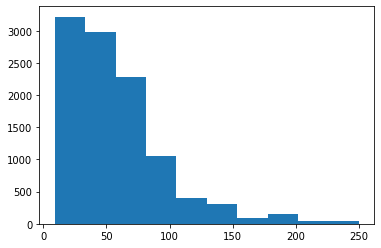

In [ ]:
# Etiqueta de la variable objetivo para el problema de regresión
y =df_airbnb_images['Price']

import matplotlib.pyplot as plt
plt.hist(y, bins=10)
plt.show()

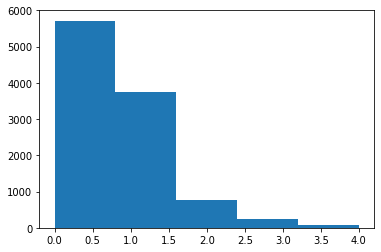

In [ ]:
# Etiqueta de la variable objetivo para el problema de clasificación
y = df_airbnb_images['Price']
y_class = []

for x in y:
    # La variable objetivo se asocia a 5 clases barato, medio, medio alto, caro y  muy caro
    if x <= 50:
        y_class.append(0)
    elif x <=100:
        y_class.append(1)
    elif x <=150:
        y_class.append(2)
    elif x <=200:
        y_class.append(3)
    else:
        y_class.append(4)

# y un rango para clasificación (del 1 al 5 por ejemplo: barato, medio, medio alto, caro y muy caro)
import matplotlib.pyplot as plt
plt.hist(y_class, bins=5)
plt.show()

#### **Regresión combinando los datos numéricos y las imágenes**

In [ ]:
from sklearn import preprocessing

# Normalización de las imágenes
scaler = preprocessing.MinMaxScaler()
airbnb_norm = scaler.fit_transform(airbnb_total)

In [ ]:
from sklearn.model_selection import train_test_split

# Normalización de las etiquetas
y_norm = y/y.max()

# Vamos a dividir en train, validation y en test pero con una muestra de 2000 registros.
# La razón por la que hago esto es porque en el proceso de entrenamiento nuestro modelo se satura y el resultado final aún modificando
# los hiperparámetros o modificando las unidades de las capas densas siempre era el mismo loss: nan - val_loss: nan
X_train, X_test, y_train, y_test = train_test_split(airbnb_norm, y_norm, test_size=0.33,  shuffle=True, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,  shuffle=True, random_state=0)

In [ ]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l1, l1_l2

# Creación del modelo MLP para el problema de regresión con imágenes la función de activación es 'linear' (sin función de activación)
model = Sequential()
model.add(Dense(16, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(1, activation='linear'))

# Optimizador Adam
opt = Adam(lr=0.001, decay=1e-6)
model.compile(loss="mean_squared_error", optimizer=opt)

# train the model
print("[INFO] training model...")
history = model.fit(x=X_train, y=y_train, 
	        validation_data=(X_val, y_val),
	        epochs=50, batch_size=16)  


[INFO] training model...
Train on 5661 samples, validate on 1416 samples
Epoch 1/50
5661/5661 [==============================] - 1s 259us/step - loss: 0.0109 - val_loss: 0.0063
Epoch 2/50
5661/5661 [==============================] - 1s 225us/step - loss: 0.0033 - val_loss: 0.0020
Epoch 3/50
5661/5661 [==============================] - 1s 220us/step - loss: 0.0011 - val_loss: 5.9326e-04
Epoch 4/50
5661/5661 [==============================] - 1s 224us/step - loss: 3.3214e-04 - val_loss: 2.2345e-04
Epoch 5/50
5661/5661 [==============================] - 1s 221us/step - loss: 1.3930e-04 - val_loss: 3.9870e-05
Epoch 6/50
5661/5661 [==============================] - 1s 225us/step - loss: 3.0827e-05 - val_loss: 1.5761e-05
Epoch 7/50
5661/5661 [==============================] - 1s 219us/step - loss: 1.6147e-05 - val_loss: 1.0450e-05
Epoch 8/50
5661/5661 [==============================] - 1s 224us/step - loss: 1.1933e-05 - val_loss: 5.4569e-06
Epoch 9/50
5661/5661 [=============================

Con un modelo MLP de una capa densa de 16 unidades con Adam (lr=0.001, decay=1e-6) como optimizador, un batch_size de 16, y con un training de 50 épocasm, el resultado de la función de perdidas tanto en train como en validation se aproxima a 0.

```
Epoch 50/50
5661/5661 [==============================] - 1s 221us/step - loss: 2.3965e-05 - val_loss: 2.8734e-06
```

In [ ]:
history.history

{'loss': [0.01089286844044887,
  0.003321016694838107,
  0.0011241819750133627,
  0.00033214309274206145,
  0.00013929827121939267,
  3.082659740900676e-05,
  1.614694043746503e-05,
  1.1933418890379288e-05,
  1.2176664360696063e-05,
  3.959148340362546e-05,
  0.0003067289736812334,
  5.877280534534945e-05,
  1.8381483067823345e-05,
  2.6421476978705214e-05,
  5.727423330444806e-05,
  0.00012529723502453742,
  0.00014679903165074052,
  0.00012829416447024972,
  6.816315569741745e-05,
  3.192298951552867e-05,
  4.8407139135574805e-05,
  6.56480291184357e-05,
  4.7604012294376136e-05,
  0.00015904930462682905,
  0.00010267864760201285,
  8.591750585702133e-05,
  8.994079275290271e-05,
  2.2824935124081455e-05,
  2.7051799876532203e-05,
  0.00010856163090046515,
  4.250074470510678e-05,
  5.8542533153027155e-05,
  3.4038349481347766e-05,
  5.810383853721768e-05,
  6.109303774725196e-05,
  0.00011325736084922905,
  9.432397386512878e-05,
  3.956008989270387e-05,
  1.3697461690769764e-05,
 

In [ ]:
history.history['loss']

[0.01089286844044887,
 0.003321016694838107,
 0.0011241819750133627,
 0.00033214309274206145,
 0.00013929827121939267,
 3.082659740900676e-05,
 1.614694043746503e-05,
 1.1933418890379288e-05,
 1.2176664360696063e-05,
 3.959148340362546e-05,
 0.0003067289736812334,
 5.877280534534945e-05,
 1.8381483067823345e-05,
 2.6421476978705214e-05,
 5.727423330444806e-05,
 0.00012529723502453742,
 0.00014679903165074052,
 0.00012829416447024972,
 6.816315569741745e-05,
 3.192298951552867e-05,
 4.8407139135574805e-05,
 6.56480291184357e-05,
 4.7604012294376136e-05,
 0.00015904930462682905,
 0.00010267864760201285,
 8.591750585702133e-05,
 8.994079275290271e-05,
 2.2824935124081455e-05,
 2.7051799876532203e-05,
 0.00010856163090046515,
 4.250074470510678e-05,
 5.8542533153027155e-05,
 3.4038349481347766e-05,
 5.810383853721768e-05,
 6.109303774725196e-05,
 0.00011325736084922905,
 9.432397386512878e-05,
 3.956008989270387e-05,
 1.3697461690769764e-05,
 4.541310978048391e-05,
 7.684490246648145e-05,


In [ ]:
history.model

In [ ]:
history.params

{'batch_size': 16,
 'do_validation': True,
 'epochs': 50,
 'metrics': ['loss', 'val_loss'],
 'samples': 5661,
 'steps': None,
 'verbose': 1}

In [ ]:
# Evaluamos la función de perdidas en test
loss = model.evaluate(X_test, y_test)
print(f'Loss={loss}')

3487/3487 [==============================] - 0s 51us/step
Loss=4.848286005756555e-06


In [ ]:
import locale

# make predictions on the testing data
print("[INFO] predicting house prices airbnb ...")
preds = model.predict(X_test)

# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(y.mean(), grouping=True),
	locale.currency(y.std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] predicting house prices airbnb ...
[INFO] avg. house price: $58.36, std house price: $39.13
[INFO] mean: 0.84%, std: 1.30%


Nuestro mean_squared_error final implica que, en promedio, nuestra red tendrá un ~ 0.84%% de descuento en sus predicciones del precio de la vivienda con una desviación estándar de ~ 1.30%. 

```
[INFO] predicting house prices airbnb ...
[INFO] avg. house price: $58.36, std house price: $39.13
[INFO] mean: 0.84%, std: 1.30%
```



#### **Clasificación con imágenes**

In [ ]:
from sklearn import preprocessing

# Normalización de las imágenes
scaler = preprocessing.MinMaxScaler()
airbnb_norm = scaler.fit_transform(airbnb_total)

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Clasificación de la etiqueta objetivo Price en 5 clases 
y_norm = to_categorical(y_class)

# Vamos a dividir en train, validation y en test con la muestra completa de las imágenes
X_train, X_test, y_train, y_test = train_test_split(airbnb_norm, y_norm, test_size=0.33,  shuffle=True, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,  shuffle=True, random_state=0)

In [ ]:
# Modelo para el problema de clasificación (función de perdida categorical_crossentropy y metrica accuracy y función de activación softmax)
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

# sparse_categorical_crossentropy es exactamente igual que categorical_crossentropy,
# solo que admite enteros en vez de onehot a la entrada
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          batch_size=32)

loss, acc = model.evaluate(X_val, y_val)
print(f'Loss={loss}, Acc={acc}')

Train on 5661 samples, validate on 1416 samples
Epoch 1/50
5661/5661 [==============================] - 1s 184us/step - loss: 0.8608 - accuracy: 0.6838 - val_loss: 0.7115 - val_accuracy: 0.7210
Epoch 2/50
5661/5661 [==============================] - 1s 144us/step - loss: 0.5793 - accuracy: 0.7771 - val_loss: 0.5543 - val_accuracy: 0.7747
Epoch 3/50
5661/5661 [==============================] - 1s 148us/step - loss: 0.4565 - accuracy: 0.8135 - val_loss: 0.4602 - val_accuracy: 0.8129
Epoch 4/50
5661/5661 [==============================] - 1s 152us/step - loss: 0.3616 - accuracy: 0.8463 - val_loss: 0.3852 - val_accuracy: 0.8468
Epoch 5/50
5661/5661 [==============================] - 1s 154us/step - loss: 0.2947 - accuracy: 0.8793 - val_loss: 0.3315 - val_accuracy: 0.8602
Epoch 6/50
5661/5661 [==============================] - 1s 150us/step - loss: 0.2510 - accuracy: 0.8965 - val_loss: 0.2863 - val_accuracy: 0.8849
Epoch 7/50
5661/5661 [==============================] - 1s 149us/step - loss

Accuracy obtenido en train es aproximadamente de un 99.91% y un 90.82% en validación, es un buenísimo resultado.

```
Epoch 50/50
5661/5661 [==============================] - 1s 151us/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 0.3583 - val_accuracy: 0.9082
1416/1416 [==============================] - 0s 69us/step
Loss=0.3583416159206865, Acc=0.9081920981407166
```



In [ ]:
# Evaluamos sobre el conjunto de test
loss, acc = model.evaluate(X_test, y_test)
print(f'Loss={loss}, Acc={acc}')


3487/3487 [==============================] - 0s 75us/step
Loss=0.4434683365362197, Acc=0.9007743000984192


Se obtiene un accuracy del 90.07% en test, que es un buen resultado ya que nos está indicando que el modelo está generalizando bastante bien.